# Data Preprocess

In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error



from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [83]:
# Load dataset
df = pd.read_csv("loan_approval_dataset.csv")
df = df.drop(columns=["loan_id"])
df.columns = df.columns.str.strip()
df.head(3)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected


In [85]:
df["loan_status"] = df["loan_status"].str.strip().map({'Rejected': 0, 'Approved': 1})

In [87]:
X = df.drop(columns=["loan_amount"])
y = df["loan_amount"]

In [89]:
# Identify numeric and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns

In [91]:
# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [93]:
# Split before scaling
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [95]:
# Scale only numerical columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Histogram

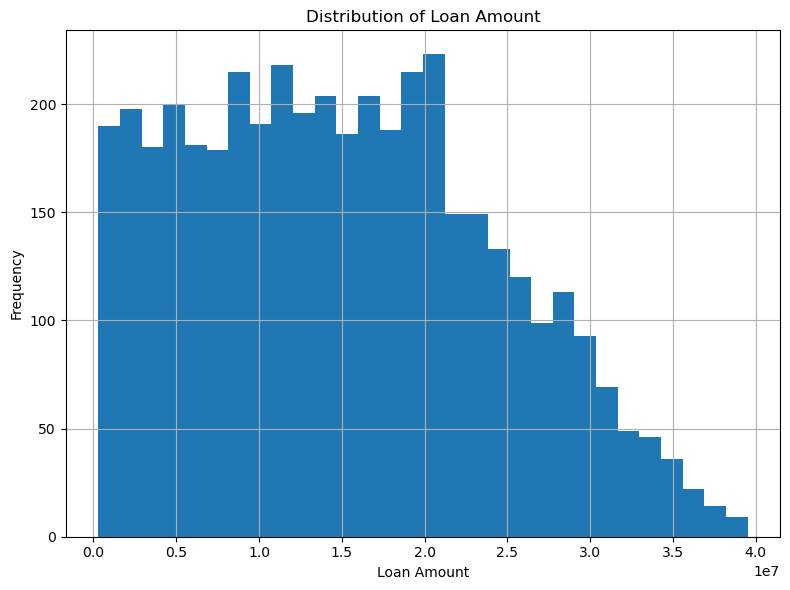

90% CI for mean loan amount: [14905786.57, 15361114.34]


In [135]:
import matplotlib.pyplot as plt

# ——— Histogram of loan_amount ———
plt.figure(figsize=(8, 6))
df['loan_amount'].hist(bins=30)      # adjust bins as you like
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amount')
plt.tight_layout()
plt.show()

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# ——— Compute 90% CI for the mean loan amount ———
loan = df['loan_amount'].dropna()
n = loan.size
mean = loan.mean()
se = stats.sem(loan)                    # standard error of the mean
z = stats.norm.ppf(0.95)               # z-value for 90% two-tailed → 0.95 percentile
ci_lower = mean - z * se
ci_upper = mean + z * se
print(f"90% CI for mean loan amount: [{ci_lower:.2f}, {ci_upper:.2f}]")

# Random Forest - Regression


         best B = {'n_estimators': 90}
  validation R2 = 0.859


<Axes: xlabel='trees'>

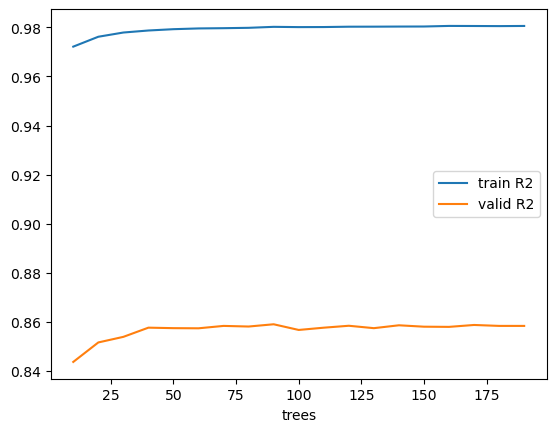

In [118]:
B = np.arange(10,200,10)
grid = {'n_estimators':B}

rf = RandomForestRegressor(max_features = 1/3)
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(X_train,y_train)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_.round(3))

results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2']  = rfCV.cv_results_['mean_test_score']
results.plot.line(x='trees',y=['train R2','valid R2'])

In [99]:
print('test R2',rfCV.score(X_test,y_test))

test R2 0.8527764615035297


In [100]:
# out-of-bag score
rf = RandomForestRegressor(n_estimators=150,max_features = 1/3,oob_score=True)
rf.fit(X_train,y_train)
print('out-of-bag R2 =',rf.oob_score_)
print()
cv_results = cross_validate(rf,X_train,y_train,return_train_score=True)
R2_trainCV = cv_results['train_score'].mean()
R2_valid   = cv_results['test_score'].mean()
print('train R2 (CV) =',R2_trainCV,'  valid R2 =',R2_valid)
print()
R2_train = rf.score(X_train,y_train)
R2_test  = rf.score(X_test,y_test)
print('     train R2 =',R2_train,'    test R2 =',R2_test)

out-of-bag R2 = 0.8592749289092578

train R2 (CV) = 0.9804530219357375   valid R2 = 0.8583140063635287

     train R2 = 0.9806417331669643     test R2 = 0.8529959918315372


In [124]:
# Predict on your test set
y_pred = rfCV.predict(X_test)

# Compute and print MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")

Test MSE: 11860211780919.613
Test MAE: 2587129.846


# Boosting

In [148]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV

In [186]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth':    [1, 3, 5, 7],
    'learning_rate':[0.01, 0.05, 0.1, 0.2]
}

# 2) set up the base estimator
gbt = GradientBoostingRegressor(random_state=42)

# 3) wrap in GridSearchCV (5-fold CV, optimizing R²)
gbtCV = GridSearchCV(
    gbt,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    return_train_score=True
)

# 4) fit on the training data
gbtCV.fit(X_train, y_train)

# 5) report best parameters and CV score
print("Best params :", gbtCV.best_params_)
print("Best CV R² :", gbtCV)

# 6) evaluate on the hold-out test set
best_gbt = gbtCV.best_estimator_
test_r2  = best_gbt.score(X_test, y_test)
print("Test R²    :", test_r2)

Best params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV R² : GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [50, 100, 200, 500]},
             return_train_score=True, scoring='r2')
Test R²    : 0.8597409128463471


In [188]:
# Predict on your test set
y_pred = gbtCV.predict(X_test)

# Compute and print MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")

Test MSE: 11246651867813.176
Test MAE: 2508932.644
